# 6.12 - Final Assignment

# Advanced Algorithms Design: Quantum Walks

Quantum walks, like their classical counterparts, describe the motion of a particle over a graph or lattice. However, they leverage quantum mechanical principles, such as superposition and interference, to exhibit behavior that can significantly differ from classical random walks. This leads to applications in quantum computing, where they can be used to design algorithms with improved performance over classical algorithms for certain problems.

## Instructions:
Create and design a quantum walk operator for the case of a line with 16 nodes

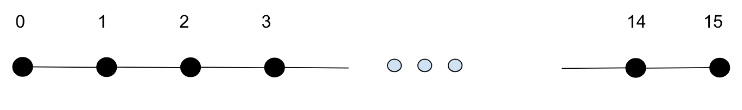

## Implementation:

The evolution part of this Quantum Walk algorithm consist in the iteratively apllication of two operators 'W' and 'S'

In [1]:
from classiq import *

In [2]:
size = 4 # Number of qubits to represent the vertices (log2 of 16 nodes)
num_nodes = 2**size # Total number of nodes (16 nodes)

## W - Operator

For my undesrtanding, 'W' operator creates superposition states between nodes based in the shape of the specific graph.

### 1. Phase Kickback

In [8]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

### 2. Implementation of W operator

In [11]:

def W_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0] * num_nodes
    if i == 0:
        prob[i + 1] = 1.0  # If at the first node, move to the right node (node 1)
    elif i == num_nodes - 1:
        prob[i - 1] = 1.0  # If at the last node, move to the left node (node 14)
    else:
        prob[i - 1] = 0.5  # Probability of moving to the left node
        prob[i + 1] = 0.5  # Probability of moving to the right node
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(num_nodes):
      W_iteration(i,vertices,adjacent_vertices)


## S - Operator

### 1. Auxiliary functions

In this graph, only neighbor nodes are connected so the oracle must check if a node is one position ahead or behind the other node.

In [16]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((adjacent_vertices == (vertices + 1)) | (adjacent_vertices == (vertices - 1)))


@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))

### 2. Implementation of S operator

'S' operator swaps the values of two nodes only when these are connected. Previous designed oracle is the piece of the algorithm that give us that information.

In [20]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

## Main

In [23]:

@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

In [25]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/4d8e0f6f-d81d-4b02-9dd3-bd63dc5441be?version=0.43.3


## Visualizing:

Here, we have the algorithm structure representation in the Classiq Platform

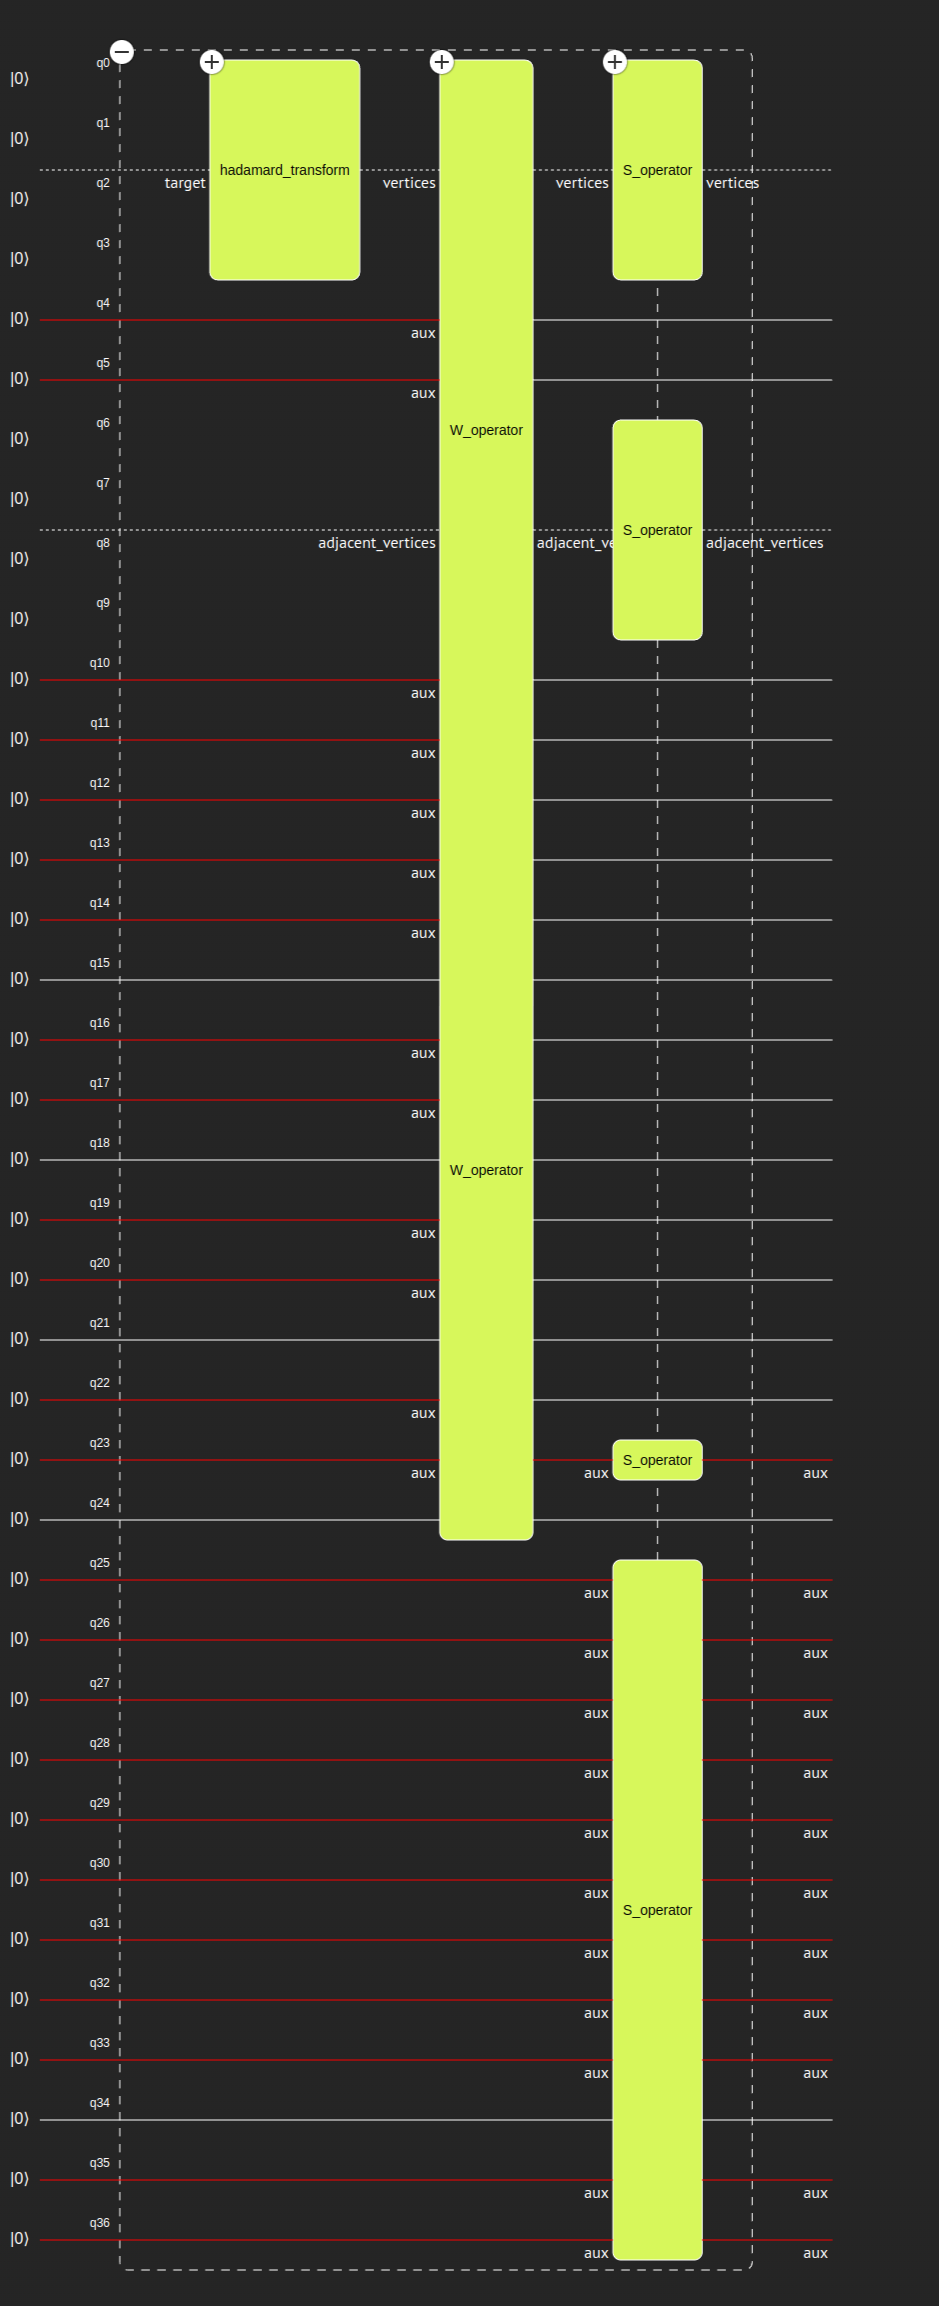